In [1]:
import glob
import numpy as np
import pandas as pd
# suppresses annoying SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

### Getting the data

In [2]:
fnames = glob.glob("gas_prices_2020-08-01_2021-01-20_5%*")

# concat all data into one dataframe
l = []
for fname in fnames:
    df = pd.read_csv(fname, index_col=None, delimiter='\t')
    l.append(df)

df = pd.concat(l, axis=0, ignore_index=True)

# convert wei to gwei
df['gasPrice'] = df['gasPrice'] / 1_000_000_000

# remove last block num just in case (files are cut off)
df = df[df.blockNum != df.blockNum.max()]

df

,blockNum,txnID,gasPrice
0,10589844,0x0368d764a0ba5f31150c1ecd71da324ddb876dd78838...,38.000000
1,10589844,0xcd24bf32d79083ed57d1eddb892d50691b2edeaddd4a...,35.000000
2,10589844,0xa8ea2350f354e418d3a6288620faa4d148d941ffd6c0...,35.000000
3,10589845,0x461090ef2e6f1167dd99afa2462c36a8bb1b93c89525...,46.200000
4,10589845,0x9518dfda776c1043af581f63834c6cf33f4fda6beb51...,45.000000
...,...,...,...
186108,10575965,0x062618aa1e05390406a17c842af518d6a335a811d078...,272.486076
186109,10575965,0x20b856cf180b34a9462593312e0f68973f7315022785...,165.558932
186110,10575965,0x5423b20931c94272f5c87bb3905c4deae34d1f3c4794...,272.486076
186111,10575965,0x2f85e3dbeb680737e0c9efd3d518205c9194c18d928b...,150.000000


# What does the distribution of gas prices in a block look like?
We normalize gas prices so to pay more attention to shape of distribution, rather than the raw gas price values.

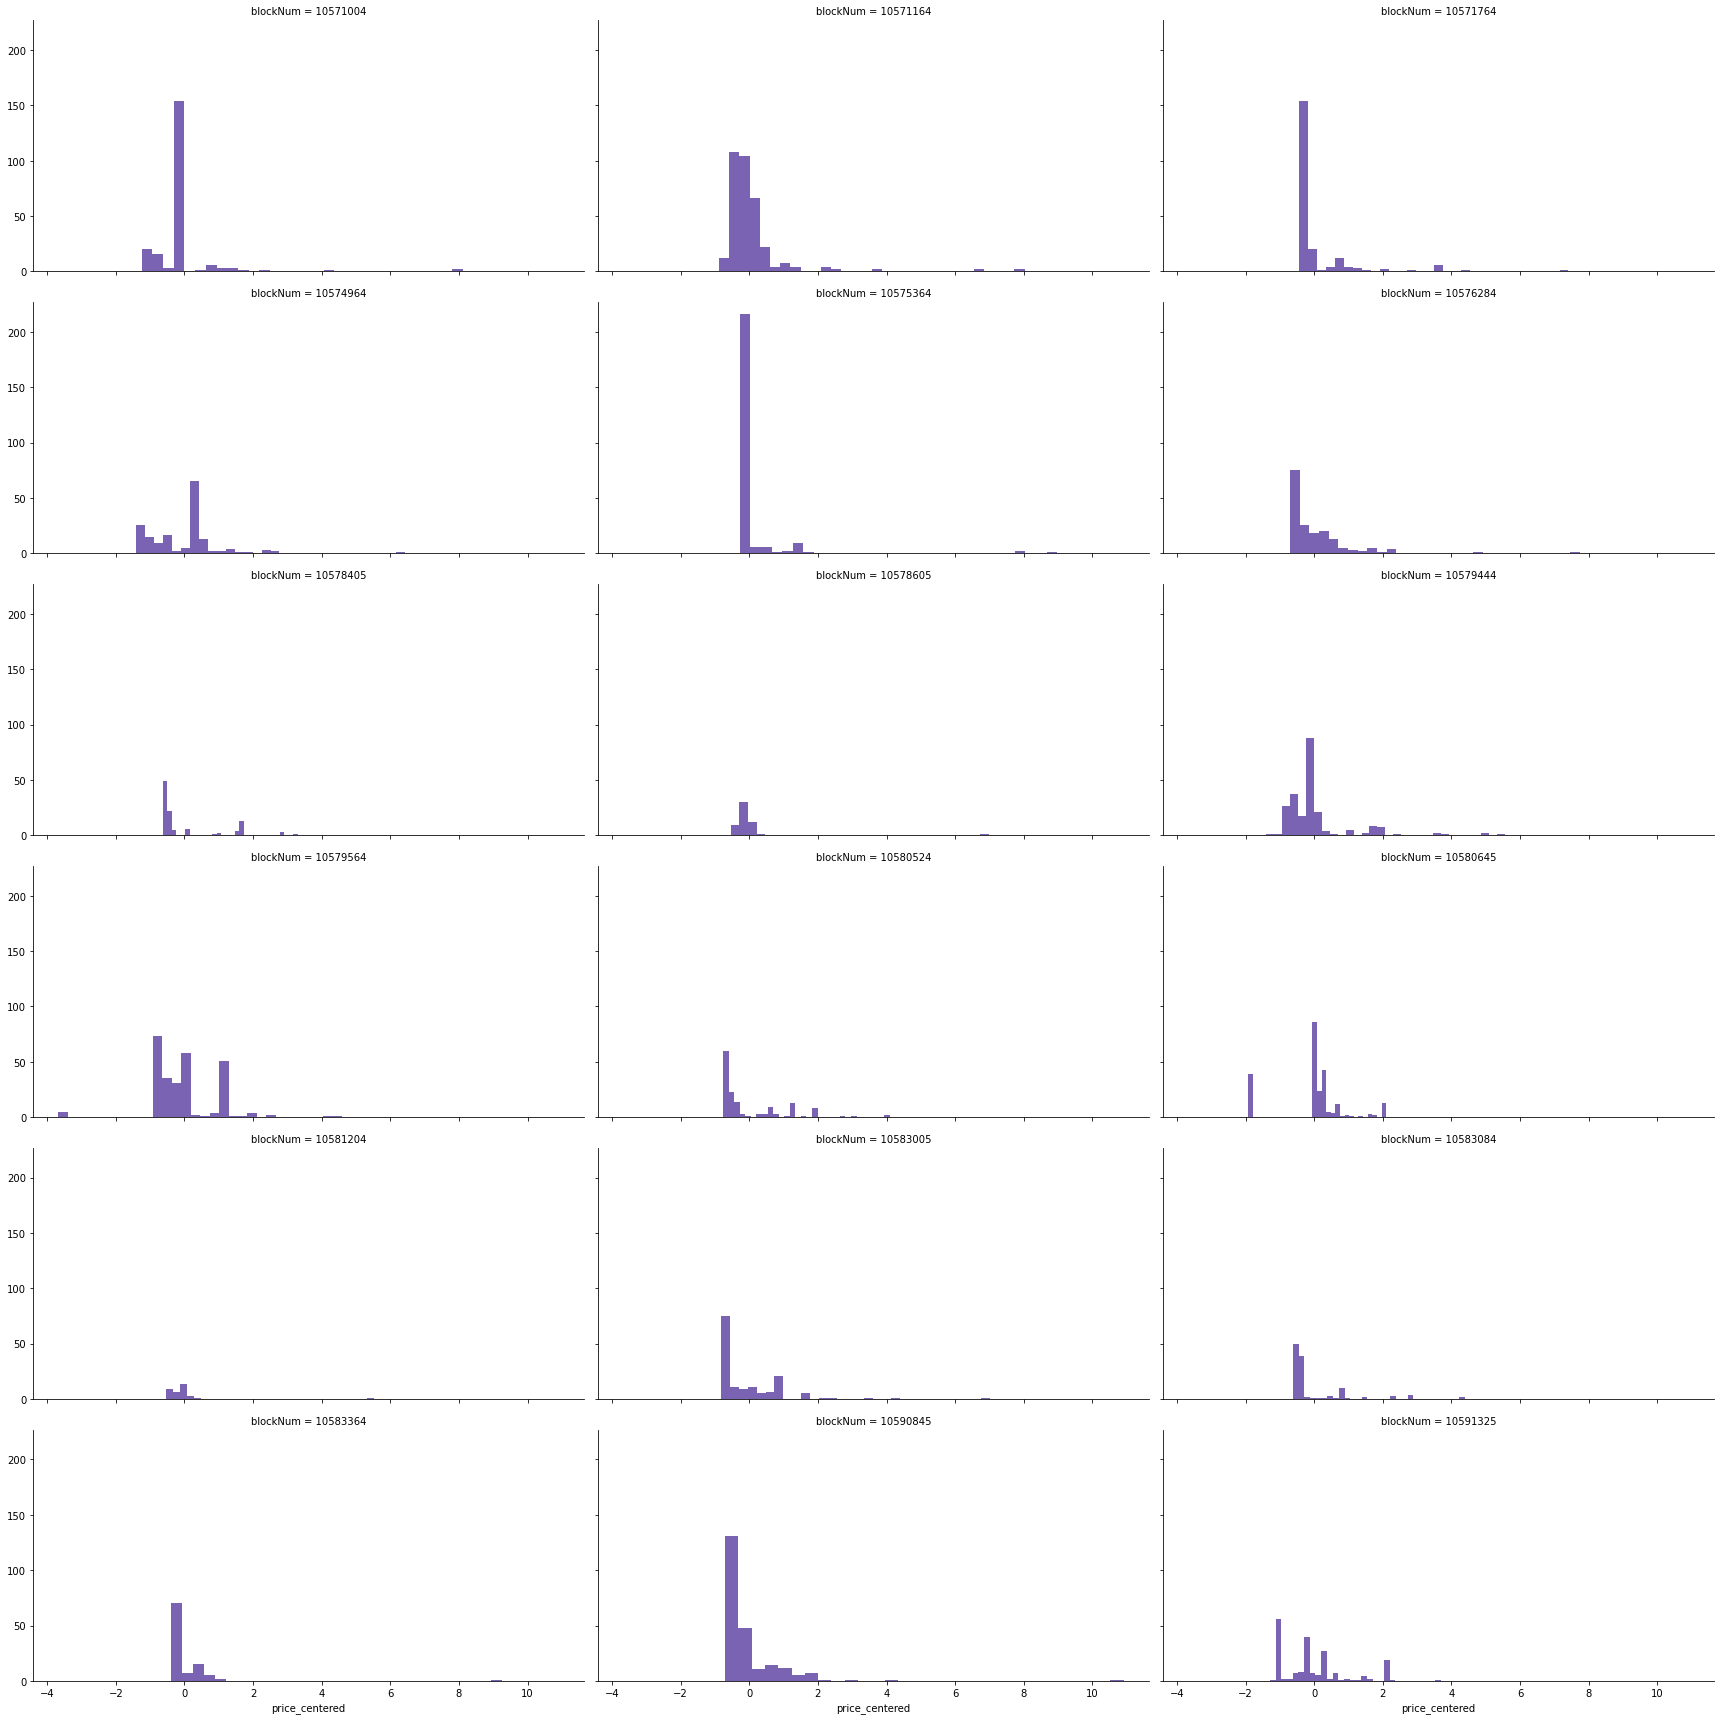

In [3]:
# randomly select blocks from the data
sample_n = 18
block_nums = random.sample(list(set(df['blockNum'])), sample_n)
df_sample = df[df.blockNum.isin(block_nums)]
# normalize
df_sample['price_centered'] = df_sample.groupby('blockNum')['gasPrice'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

g = sns.FacetGrid(df_sample, col="blockNum", col_wrap=3, height=4, aspect=2)
g.map(
    sns.distplot, "price_centered", rug=False,
    hist_kws=dict(alpha=1), **{'bins': 30, 'color': API3_PURPLE},
    kde=False
);

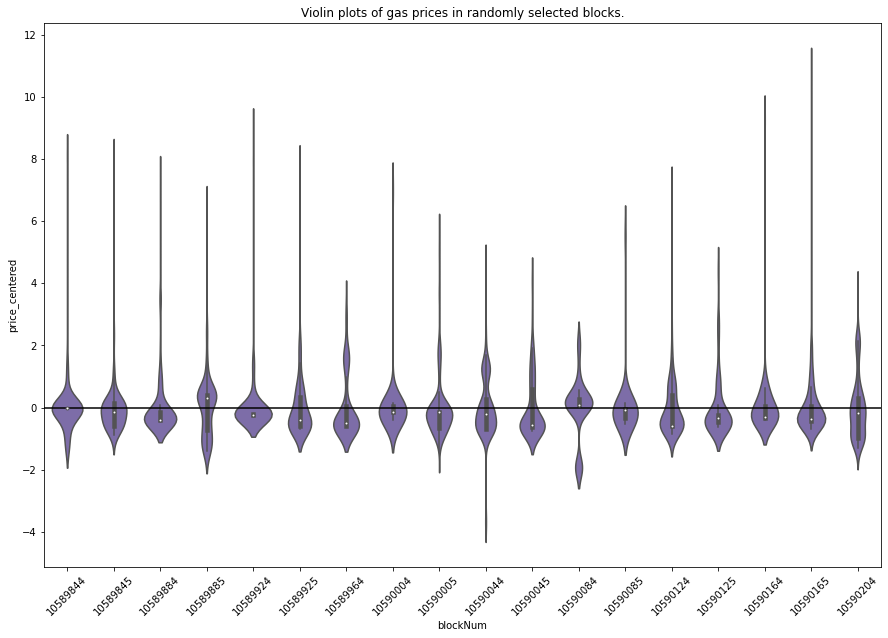

In [4]:
# violin plots to visually detect skewness
_, ax = plt.subplots(1, 1, figsize=(15,10))
g = sns.violinplot(
    ax=ax,
    x="blockNum",
    y="price_centered",
    height=1,
    aspect=1,
    color=API3_PURPLE,
    data=df_sample
)

g.set_title('Violin plots of gas prices in randomly selected blocks.')

g.set_xticklabels(
    labels=df['blockNum'].unique(),
    fontdict={'fontsize': 10},
    rotation=45
);
ax = g.axes
ax.axhline(0, color='black');

## Comments
- There's clearly a strong right skew -- this makes sense: there's probably some frontrunning (or, less extreme, just people needing txns confirmed quickly) in each block which causes the right skew (towards higher gas prices)
- The mode tends to be around the lowest gas price in a block. This is more evident in the first set of plots.
    - This is potentially concerning to our analysis. Consider the mode being $x$ in block $B$, the minimum gas price in a block. I think this would imply that there are probably plenty of txns in the mempool that have that same gas price (consider: what are the chances that all txns in the mempool with gas price $x$ get mined in block $B$).
    - That is, I don't think we can assume having a txn with the minimum gas price mined in a given block implies it would get mined. A safer assumption would probably be having the gas price be *strictly* greater.
- I think there's a lot potentially to look at with the outliers/skew: for one thing, I wonder if the degree of skew is a predictor of increasing gas prices?

# How many of these transactions have a gas price greater than the min of the next block?

In [5]:
# get minimum gas price for each block
df_mins = df.groupby("blockNum", as_index=True)["gasPrice"].min()
df_mins

blockNum
10570484    45.100000
10570485    45.000000
10570524    44.000000
10570525    45.000000
10570564    41.000000
              ...    
10591325    41.000000
10591364     1.000000
10591365    56.000001
10591404    46.000000
10591405    50.000000
Name: gasPrice, Length: 1008, dtype: float64

In [6]:
def f(row):
    if row['blockNum'] + 1 not in df_mins.index:
        return np.nan
    elif row['gasPrice'] > df_mins.loc[row['blockNum'] + 1]:
        return 1
    else:
        return 0
    
df['is_greater_than_min_next_block'] = df.apply(f, axis=1)

In [7]:
df[df['is_greater_than_min_next_block'] == np.nan]

,blockNum,txnID,gasPrice,is_greater_than_min_next_block


In [8]:
res = df.groupby('is_greater_than_min_next_block').count()
res

,blockNum,txnID,gasPrice
is_greater_than_min_next_block,,,
0.0,13178,13178,13178
1.0,75969,75969,75969


In [9]:
# total proportion of all txns
res.loc[1].blockNum / (res.loc[0].blockNum + res.loc[1].blockNum)

0.8521767417860387

## What about distribution per block?
I.e. is there a lot of variability with this proportion block to block?

In [10]:
df_ = df.dropna()
print('total number of blocks:')
print(len(df_.blockNum.unique()))

total number of blocks:
484


In [11]:
grouped = df_.groupby('blockNum').mean()
grouped

,gasPrice,is_greater_than_min_next_block
blockNum,,
10570484,68.802892,1.000000
10570524,51.215623,0.360731
10570604,55.907080,1.000000
10570644,61.264310,1.000000
10570684,47.645609,1.000000
...,...,...
10591244,39.365969,0.926724
10591284,427.035560,1.000000
10591324,64.027147,1.000000


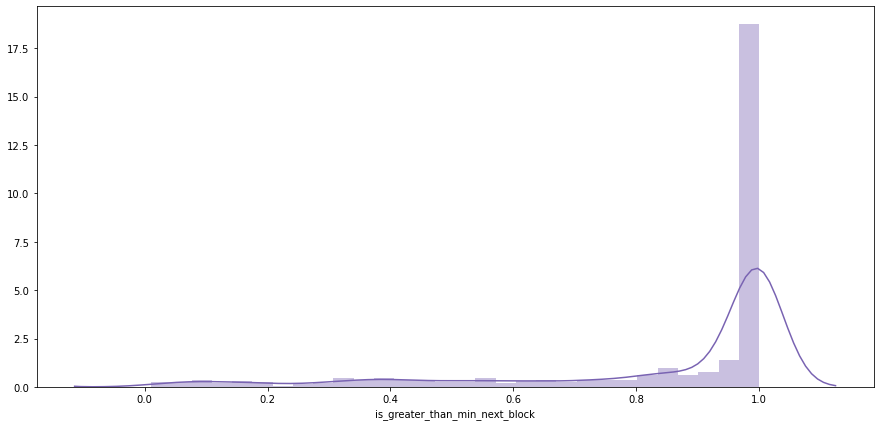

In [12]:
_, ax = plt.subplots(1, 1, figsize=(15,7))
sns.distplot(grouped["is_greater_than_min_next_block"], kde=True, **{'bins': 30, 'color': API3_PURPLE});

### How many blocks have *all* txns satsifying the condition?
where condition == the gas price is *strictly greater* than the min of the next block

In [13]:
(grouped["is_greater_than_min_next_block"] > 0.999).mean()

0.5082644628099173

### How many blocks have *none* of the txns satisifying the condition?

In [14]:
(grouped["is_greater_than_min_next_block"] <= 0.001).mean()

0.0

### How many blocks have *less than half* satisifying the condition?

In [15]:
(grouped["is_greater_than_min_next_block"] < 0.5).mean()

0.13636363636363635

## Comments:
This is kind of what I was expecting / worried about: *most* of the time this works fine (this == picking a random txn from block $x$, taking it's gas price, and having it be greater than the min of the next block). It's outlier conditions that are worrisome; e.g. those ~15% of blocks that have only 50% of txns satisfy the condition. This implies there's some analysis to be done on these outlier / long-tail scenerios.

In [ ]:
### Quick test: is condition satisfication correlated 

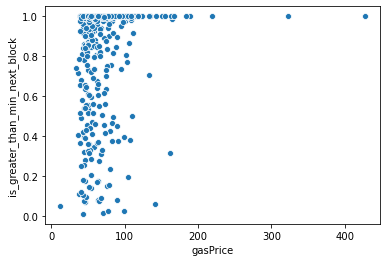

In [22]:


sns.scatterplot(data=grouped, x="gasPrice", y="is_greater_than_min_next_block")

### TODO:
- Further analysis into those outlier cases / long-tail scenerios